_Version log: Finding the best samples though brute force and manual tweaking_

In [9]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft
from tqdm import tqdm
from matplotlib import cm as mplcolormaps, colors as mplcolors

warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [10]:
def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
        if array.ndim == 2:
            return array.T
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    mean = np.nanmean(samples) # LASSO IGNORES THE MEAN. lasso automatically normalises the samples such that they have a mean of 0. It therefore, cannot recover the zero frequency.

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward") +mean

    return result


def subsample_1d(total_points, reduced_points, subsampling_method = "random"):

    if subsampling_method == "random":
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)
    elif subsampling_method == "regular":
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
    elif subsampling_method == "centered":
        subsampled_points = np.arange((total_points-reduced_points)//2, (total_points+reduced_points)//2)

    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

def argmin(array): # numpy argmin always flattens the array
    return np.unravel_index(np.argmin(array, axis=None), array.shape)

In [11]:
file_name = "1dmockanderrors12"
file_type = ".csv"

target, uncertainties = open_dataset(file_name, file_type)
total_points = len(target)

In [12]:
reduced_points = 8
regularization_coeffient = 1e-4

#initial_detectors = [] #custom
initial_detectors = subsample_1d(total_points, reduced_points, subsampling_method= "centered")

In [13]:
iterations = 1000
tolerance = 1e-4

detectors = np.copy(initial_detectors)
errors = np.empty((reduced_points, total_points))
scores = np.array([])

for m in tqdm(range(iterations)):

    for n in np.arange(reduced_points):
        trail_detectors = np.copy(detectors)
        for trail_detector in np.arange(total_points):
            trail_detectors[n] = trail_detector

            result = compressed_sensing(target[trail_detectors], trail_detectors, total_points, regularization_coeffient)
            error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

            errors[n, trail_detector] = error

    scores = np.append(scores, np.min(errors))

    try:
        change = -np.max(np.diff(scores)) #scores should always decrease (lower scores are better).
        if change < tolerance:
            print(change)
            break
    except ValueError:
        pass

    detector_to_move, new_position = argmin(errors)
    detectors[detector_to_move] = new_position

  0%|          | 5/1000 [01:52<6:14:11, 22.56s/it]

-0.0


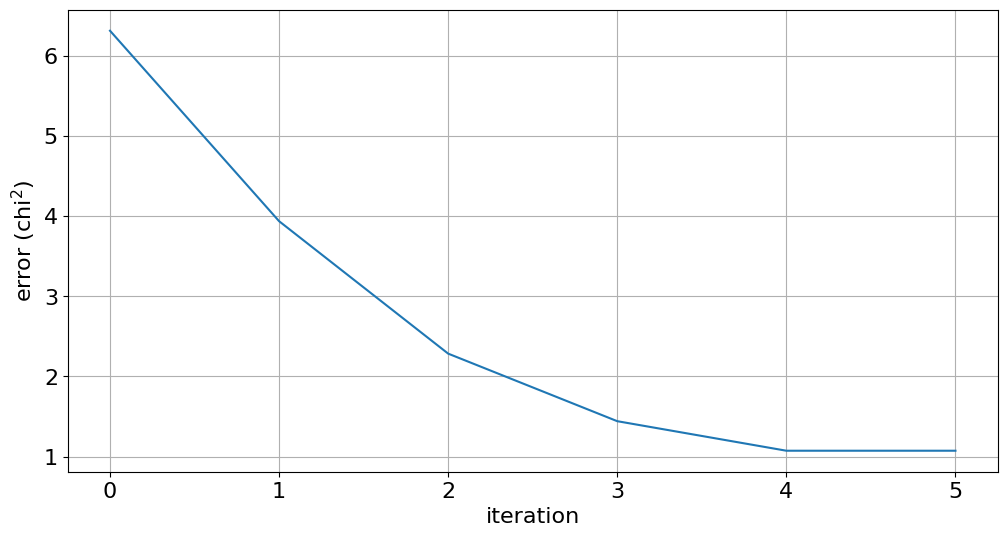

In [14]:
fig, axs = plt.subplots(figsize= (12,6))

axs.plot(scores)
axs.grid(True)
axs.set(ylabel= "error (chi$^2$)", xlabel= "iteration")

plt.show()

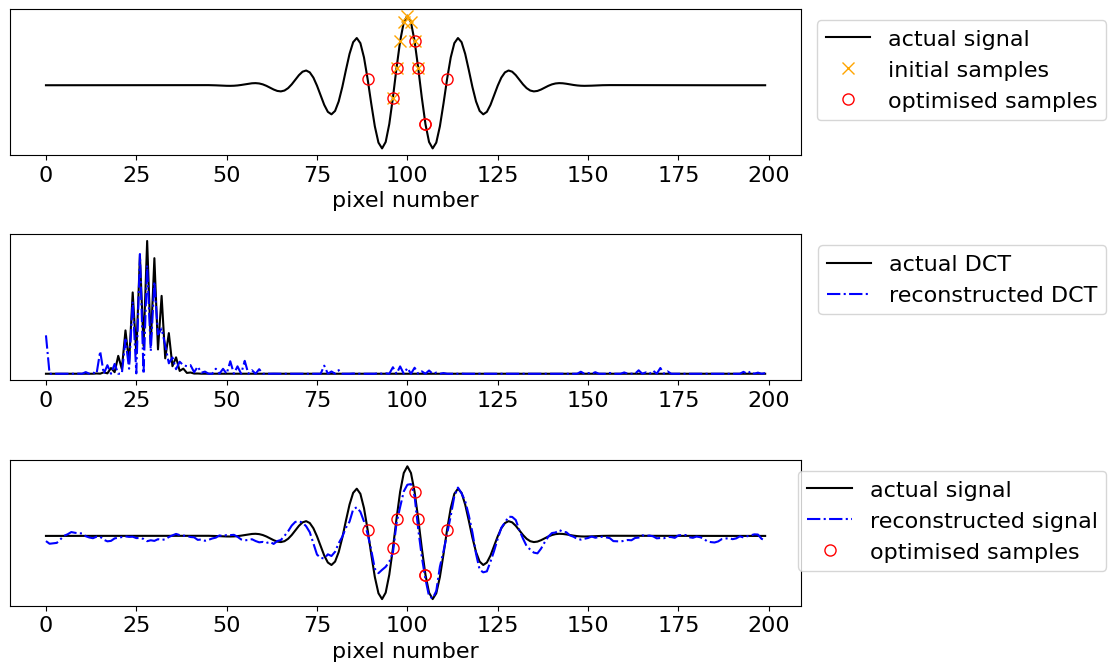

In [15]:
result_DCT = spfft.dct(result, norm= "forward")
target_DCT = spfft.dct(target, norm= "forward")


plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(initial_detectors, target[initial_detectors], marker= "x", markerfacecolor= "None", markersize= 8, color= "orange", linestyle= "None", label= "initial samples")
axs[0].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[0].set(xlabel= "pixel number")

axs[1].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[1].plot(np.abs(result_DCT), color= "blue", label= "reconstructed DCT", linestyle= "-.")

axs[2].plot(target, color= "k", label= "actual signal")
axs[2].plot(result, color= "blue", label= "reconstructed signal", linestyle= "-.")
axs[2].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right', bbox_to_anchor=(1.4, 1)) for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()

In [16]:
print(*np.sort(detectors), sep= ",")

89,96,97,102,103,105,105,111
